In [1]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
homedir = expanduser("~")
from astropy.io import ascii
%matplotlib inline
from scipy import stats
import ast

In [2]:
def strip_diction(s):
        #from string to dictionary
        return pd.Series(ast.literal_eval(((s.strip().replace('nan', "'nan'").replace('-inf', "'nan'")).replace('inf', "'nan'"))))
    
def reformat_index_table(df):
    #assign dictionary keys
    ids_list=[]
    snr_list=[]
    for k in df.columns:
        first=df[k].iloc[0]
        print (k)
        if isinstance(first, str):
            if first.strip().startswith("{"):
                if not k=='indices':
                    snr_list.append(df[k].apply(lambda x: strip_diction(x)))
                else:
                    ids_list.append(df[k].apply(lambda x: strip_diction(x)).applymap(tuple))
      
    
    return snr_list, ids_list

def replace(x):
    #print (x)
    if (isinstance(x, float)):
        if (np.isnan(x)):
            return tuple([np.nan, np.nan])
    else:
        return x
    
def comp_f_test(tupl):
    num=tupl[0]
    den=tupl[1]
    if den ==0: return np.nan
    else:
        x=num/den
        return stats.f.cdf(x, 2, 1, 0, scale=1)

In [3]:
#get photometry catalogs
w_phot=pd.read_csv(wisps.OUTPUT_FILES+'/wisp_photometry.csv')
hst_phot=pd.read_csv(wisps.OUTPUT_FILES+'/hst3d_photometry_all.csv')

In [4]:
#use the indices
hst_3d_indices=pd.read_pickle('/users/caganze/new_indices_measurements_october.pkl')
wisp_indices=pd.read_pickle('/users/caganze/new_wisps_indices_measurements_october.pkl')

In [5]:
#drop nan columns
hst_3d_indices=(hst_3d_indices[~ hst_3d_indices.isnull().all(1)])

In [6]:
#combine both
new_indices=pd.concat([wisp_indices,hst_3d_indices ])

In [7]:
new_indices=new_indices[~ new_indices.isnull().all(1)]

In [8]:
new_indices.shape

(761000, 20)

In [9]:
#old_indices
cols=['name', 'snr', 'spex_chi', 'line_chi', 'spt', 'indices']
old_indices=pd.read_csv('~/wisp_indices.txt', names =cols, delimiter ='\t')

In [10]:
snr_list, ids_list=reformat_index_table(old_indices)
fmtids=(pd.concat(snr_list).join(pd.concat((ids_list )))).replace('nan', np.nan)

name
snr
spex_chi
line_chi
spt
indices


In [11]:
fmtids[wisps.INDEX_NAMES].iloc[0]['H_2O-1/J-Cont' ]

(1.0909776305129566, 0.014650873974899593)

In [12]:
def replace_new_with_old_where_nan(column):
    #replaces new index with olf index if nan
    col

In [13]:
new_indices[(wisps.Annotator.reformat_table(new_indices)[wisps.INDEX_NAMES]).isnull().all(1)]

,CH_4/H-Cont,CH_4/H_2O-1,CH_4/H_2O-2,CH_4/J-Cont,H-cont/H_2O-1,H-cont/H_2O-2,H-cont/J-Cont,H_2O-1/J-Cont,H_2O-2/H_2O-1,H_2O-2/J-Cont,cdf_snr,f_test,line_chi,name,snr1,snr2,snr3,snr4,spex_chi,spt
6,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",14.439330,1.000000,0.000000,par321-00287,NaN,NaN,NaN,NaN,1.000000e-60,L0.0
17,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",3.670267,1.000000,0.000000,par321-00376,NaN,NaN,NaN,NaN,1.000000e-60,L0.0
29,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",2.186004,1.000000,0.000000,par321-00653,NaN,NaN,NaN,NaN,1.000000e-60,L0.0
40,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",NaN,1.000000,0.000000,par321-00481,NaN,NaN,NaN,NaN,1.000000e-60,L0.0
50,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)",NaN,1.000000,0.000000,par321-00264,NaN,NaN,NaN,NaN,1.000000e-60,L0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235926,"(1.0216846708746152, 0.0)","(0.045815596483300754, 0.0)","(1.6746058178174605, 0.0)","(-0.540022191179014, 0.0)","(0.044843186737920045, 0.0)","(1.6390632702592187, 0.0)","(-0.5285605300476192, 0.0)","(-11.786863702098602, 0.0)","(0.0273590333891309, 0.0)","(-0.3224771975788507, 0.0)",111.065443,0.211279,38.609610,goodsn-13-G141_21342.1D.ascii,-0.000001,5.908453e-07,6.546530e-07,4.458627e-07,1.172781e+01,T8.0
235941,"(1.2504022316590122, 0.0)","(1.801543980713708, 0.0)","(0.9783230373340567, 0.0)","(6.663959181737227, 0.0)","(1.4407715654213527, 0.0)","(0.7824066628832184, 0.0)","(5.329452405803531, 0.0)","(3.6990266421901077, 0.0)","(1.8414612678680646, 0.0)","(6.811614290405146, 0.0)",277.690888,0.403643,336.750251,goodsn-13-G141_18967.1D.ascii,2.309465,2.472423e+00,2.475724e+00,2.504135e+00,3.050658e+02,M0.0
235951,"(0.5355065131194822, 0.0)","(0.6232573592559626, 0.0)","(0.6808990782422197, 0.0)","(3.468713272859216, 0.0)","(1.163865133264778, 0.0)","(1.2715047558913586, 0.0)","(6.477443668524116, 0.0)","(5.565458989525812, 0.0)","(0.9153446952299267, 0.0)","(5.09431336258216, 0.0)",263.306754,0.407292,331.705198,goodsn-13-G141_23221.1D.ascii,1.747306,2.229555e+00,2.512612e+00,2.156207e+00,3.062543e+02,M0.0
235963,"(0.43126159545256587, 0.0)","(0.4657905348581254, 0.0)","(0.22079562753720955, 0.0)","(0.4464869113320863, 0.0)","(1.0800649530810293, 0.0)","(0.5119760949395613, 0.0)","(1.0353041310426516, 0.0)","(0.9585572868458592, 0.0)","(2.1096003578224307, 0.0)","(2.022172795323323, 0.0)",324.262804,0.416926,514.114497,goodsn-13-G141_21941.1D.ascii,3.179967,1.783721e+00,1.106399e+00,2.451091e+00,4.990485e+02,M0.0


In [14]:
#cols=list(wisps.INDEX_NAMES)

In [15]:
def combined_wisp_hst_catalogs(hst3d_phot,wisp_phot, indices):
    """
    combine both hst-3d and wisps into one big file with all the information
    """
    #hst_3d does not have 110 photometry
    hst3d_phot['F110_mag']=np.nan
    hst3d_phot['F110_mag_er']=np.nan

    
    #combine flags into one flag
    flgs=hst3d_phot[['use_phot_x', 'f_cover', 'f_flagged', 'f_negative']].values
    hst3d_phot['phot_flags']= pd.Series([i for i in flgs])
    
    hst3d_phot['survey']='HST3D'
    wisp_phot['survey']='WISP'
    wisp_phot=wisp_phot.rename(columns={'EXTRACTION_FLAG':'phot_flags'})
   
    #rename some columns
    indices=indices.rename(columns={'name':'grism_id'})
    
    ##drop .ascii from hst_phot
    indices['grism_id']=indices['grism_id']
    
    #combined_photometry (the order matters: HST3D+WISPP
    comb_phot=pd.DataFrame()
    grism_ids=hst3d_phot['grism_id'].append(wisp_phot['grism_id'])
    star_flags=hst3d_phot['star_flag'].append(wisp_phot['star_flag'])
    comb_phot['grism_id']=grism_ids
    comb_phot['star_flag']=star_flags
    comb_phot['class_star']=hst3d_phot['class_star'].append(wisp_phot['star_flag'])
    
    print(comb_phot.columns)
    for flt in ['110', '140', '160']:
        mag_tuple1=hst3d_phot[['F'+flt+'_mag', 'F'+flt+'_mag_er']].apply(tuple, axis=1)
        mag_tuple2=wisp_phot[['NIMCOS_'+flt+'W', 'NIMCOS_'+flt+'W_ER']].apply(tuple, axis=1)
        mags=mag_tuple1.append(mag_tuple2)
        comb_phot['F'+flt]=mags
        
    ras=hst3d_phot['ra_x'].append(wisp_phot['RA'])
    decs=hst3d_phot['dec_x'].append(wisp_phot['DEC'])
        
    comb_phot['RA']=ras
    comb_phot['DEC']=decs
    comb_phot['survey']=hst3d_phot['survey'].append(wisp_phot['survey'])
    #comb_phot['flags']=hst3d_phot['flags'].append(wisp_phot['flags'])
    
    #strip white spaces from grism_ids #the combination might pose problems
    comb_phot['grism_id']=comb_phot['grism_id']
    indices['grism_id']=indices['grism_id']
    
    indices=indices.drop_duplicates(subset='grism_id')
    comb_phot=comb_phot.drop_duplicates(subset='grism_id')
    
    comb_phot.grism_id=comb_phot.grism_id.apply(lambda x: x.replace('.1D.ascii', ' ').strip().lower())
    indices.grism_id=indices.grism_id.apply(lambda x: x.replace('.1D.ascii', ' ').strip().lower())
    
    print (comb_phot.grism_id.iloc[0], indices.grism_id.iloc[0])
    master_table=pd.merge(indices, comb_phot, on='grism_id', validate='one_to_one')
    
    # I probably lost tons of objects with grism id ='0000'
    print (master_table.shape, comb_phot.shape, indices.shape)

    
    master_table[['spex_chi', 'line_chi']]=master_table[['spex_chi', 'line_chi']].applymap(np.float)
    master_table['x']=master_table.spex_chi/master_table.line_chi
    master_table['f_test']=master_table.f_test

    #save the result
    #master_table=master_table.join(df)

    #drop the spectrum column because it makes the file heavier
    #master_table=master_table.drop(columns='spectra')

    #make the cut 
    

    return master_table

In [16]:
hst_phot.shape, w_phot.shape

((79609, 435), (204078, 30))

In [17]:
mdf=combined_wisp_hst_catalogs(hst_phot, w_phot, new_indices)

Index(['grism_id', 'star_flag', 'class_star'], dtype='object')
aegis-26-g141_00002 par321-00514
(271915, 28) (279595, 9) (430098, 20)


In [18]:
mdf.shape

(271915, 29)

In [19]:
#get all the observation info for each field
obs=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')
obs=obs.drop(columns=['Unnamed: 0']).drop_duplicates(subset='POINTING').reindex()

In [20]:
obs.columns=[x.lower() for x in obs.columns]

In [21]:
obs.columns

Index(['ra (deg)', 'dec(deg)', 'l (deg)', 'b (deg)', 'exposure (s)',
       'observation date (ut)', 'pointing'],
      dtype='object')

In [22]:
(obs[obs.pointing=='par1'])['exposure (s)'].values[0]

2609.0

In [23]:
def get_proper_pointing(grism_id):
    grism_id=grism_id.lower()
    if grism_id.startswith('par'):
        return grism_id.split('-')[0]
    else:
        return grism_id.split('-g141')[0]
    
def get_time(pntg):
    try:
        g=(obs[obs.pointing==pntg])[['exposure (s)', 'observation date (ut)']]
        return g.values[0]
    except:
        return (np.nan, np.nan)

def add_pointing_information(row):
    
    pntg=get_proper_pointing(row.grism_id)
    obst,   obsdate = get_time(pntg)
    s3 = pd.Series({'pointing':pntg, 'exposure_time': obst, 'observation_date':obsdate})
    row=row.append(s3)
    return row

In [24]:
obs.columns=obs.columns.str.lower()

In [25]:
mt=mdf.reset_index(drop=True).apply(add_pointing_information, axis=1)

In [26]:
mt.exposure_time.values, mt.shape

(array([4915., 4915., 4915., ..., 3812., 3812., 3812.]), (271915, 32))

In [27]:
mt.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')

In [28]:
obs.columns

Index(['ra (deg)', 'dec(deg)', 'l (deg)', 'b (deg)', 'exposure (s)',
       'observation date (ut)', 'pointing'],
      dtype='object')

In [29]:
stars=mt[mt.class_star !=0.]

In [30]:
stars.shape

(110930, 32)

In [31]:
stars.to_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars')

In [32]:
st=wisps.Annotator.reformat_table(stars)

In [33]:
snrs=(st[st.F140.between(18.0, 26.)]).snr1.values
mags=(st[st.F140.between(18.0, 26.)]).F140.values
xs=(st[st.F140.between(18.0, 26.)]).f_test.values

In [34]:
idx=np.logical_and(snrs<200., snrs>0.1)

In [35]:
st.columns

Index(['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'cdf_snr', 'f_test', 'line_chi',
       'grism_id', 'snr1', 'snr2', 'snr3', 'snr4', 'spex_chi', 'spt',
       'star_flag', 'class_star', 'F110', 'F140', 'F160', 'RA', 'DEC',
       'survey', 'x', 'pointing', 'exposure_time', 'observation_date'],
      dtype='object')

In [36]:
import seaborn as sns

In [37]:
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

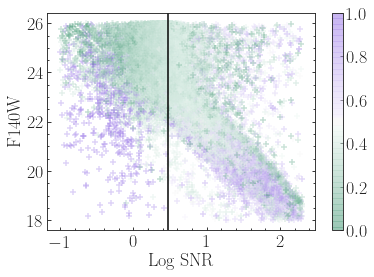

In [38]:
c=plt.scatter(np.log10(snrs[idx]), mags[idx], marker='+', alpha=0.3, c=xs[idx], cmap=cmap)
plt.xlabel('Log SNR', fontsize=18)
plt.ylabel('F140W', fontsize=18)
plt.axvline(np.log10(3.), c='k')
plt.minorticks_on()
plt.colorbar()